In [4]:
# Imports
import numpy as np
from matplotlib import pyplot as plt

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Load from https://github.com/markusmeister/Rosenberg-2021-Repository
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

In [5]:
# Load the trans_probs
trans_probs = np.load('../data/trans_probs.npy')

In [6]:
def compute_prev_state_map(trans_probs):
    n_state = trans_probs.shape[0]
    prev_state_map = {x: [] for x in range(n_state)}
    
    # Loop through trans_probs to find valid previous states for each x
    for x in range(n_state):
        for prev_x in range(n_state):
                if np.sum(trans_probs[prev_x, :, x]) > 0:
                        prev_state_map[x].append(prev_x)
    
    return prev_state_map

prev_state_map = compute_prev_state_map(trans_probs)

In [7]:
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
ma=NewMaze(6)
no_list = []
act_list = []
emissions_list = []
nose_pos_list = []
names = []
times = []
xy_list = []
k_list = []
b_list = []

traj = []
act = []
emission = []
time = []
nose_pos = []
x = []
y = []
bs = []

action_arr = MakeStepType(ma)
tc=[]
for i,nickname in enumerate(RewNames):
    tf=LoadTraj(nickname+'-tf')
    ba=np.array([[b[0]/30,b[1]/30] for b in tf.fr]) # start and end of each bout in s
    tc+=[np.array(ba[1:,0]-ba[:-1,1])]
    for j in range(0, len(tf.no)):
        n = tf.no[j]
        b = tf.fr[j]
        k = tf.ke[j]

        for t in range(0, n.shape[0]-1):
            if len(traj) == 500:
                if np.count_nonzero(np.array(traj) == 116) < 7 or np.count_nonzero(np.array(traj) == 0) < 7:
                    traj.pop(0)
                    act.pop(0)
                    emission.pop(0)
                    x.pop(0)
                    y.pop(0)
                    time.pop(0)
                    bs.pop(0)
                else:
                    no_list.append(traj)
                    act_list.append(act)
                    emissions_list.append(emission)
                    k_list.append(k)
                    xy_list.append([x, y])
                    names.append(nickname)
                    times.append(time)
                    b_list.append(bs)
                    traj = []
                    act = []
                    emission = []
                    x = []
                    y = []
                    time = []
                    bs = []
            if len(traj) > 0:
                if traj[-1] not in prev_state_map[n[t, 0]]:
                    traj = []
                    act = []
                    emission = []
                    time = []
                    x = []
                    y = []
                    bs = []
                    print(n[t, 0], traj[-1])
            
            traj.append(n[t, 0])
            act.append(action_arr[n[t, 0], n[t+1, 0]])
            emission.append([n[t, 0], action_arr[n[t, 0], n[t+1, 0]]])
            time.append(n[t, 1])
            x.append(k[n[t, 1],0])
            y.append(k[n[t, 1],1])
            bs.append(b)

In [8]:
def compute_trial_time(trial):
    total_time = 0
    first_time = trial[0]
    for i in range(1, len(trial)):
        if trial[i] < trial[i - 1]:  # Wrap-around detected
            total_time += trial[i - 1] - first_time
            first_time = trial[i]
    total_time += trial[-1] - first_time  # Add remaining segment
    return total_time

trial_times = np.array([compute_trial_time(trial) for trial in np.array(times)])


In [9]:
emissions = np.array(emissions_list)
times = np.array(times)
b_list = np.array(b_list)

2
2
2
3
3
4
5
6
7
7
8
8
8
11
12
12
12
12
12
13
13
13
14
17
19
20
21
22
24
24
24
26
26
27
28
29
31
31
31
31
31
32
32
32
32
33
33
33
34
34
34
35
35
35
35
36
36
36
36
36
38
39
40
40
40
40
40
41
41
42
42
42
42
42
43
43
43
43
44
44
44
44
44
44
44
49
49
51
51
53
53
55
56
57
57
58
58
58
60
61
61
61
63
64
65
65
66
66
66
67
67
67
68
69
70
70
70
70
71
73
74
74
74
75
76
77
78
78
80
80
80
80
81
81
81
81
82
82
82
83
84
85
85
86
86
87
87
87
88
89
89
89
90
91
92
92
92
92
92
92
93
94
94
95
95
95
95
95
95
95
96
96
97
97
98
98
98
98
100
102
102
104
106
107
111
113
113
114
115
116
116
117
118
119
120
123
124
125
125
126
126
127
127
130
130
130
131
131
131
131
131
131
132
133
134
135
135
136
137
138
138
140
141
142
143
145
145
145
146
146
146
146
146
147
147
147
147
148
148
149
149
149
150
150
152
152
153
154
155
158
158
158
160
161
162
164
165
165
167
168
169
170
172
172
174
175
175
176
176
182
182
182
184
184
185
185
189
189
191
192
192
195
195
196
196
196
197
198
198
199
202
202
202
203
203
204
205
208

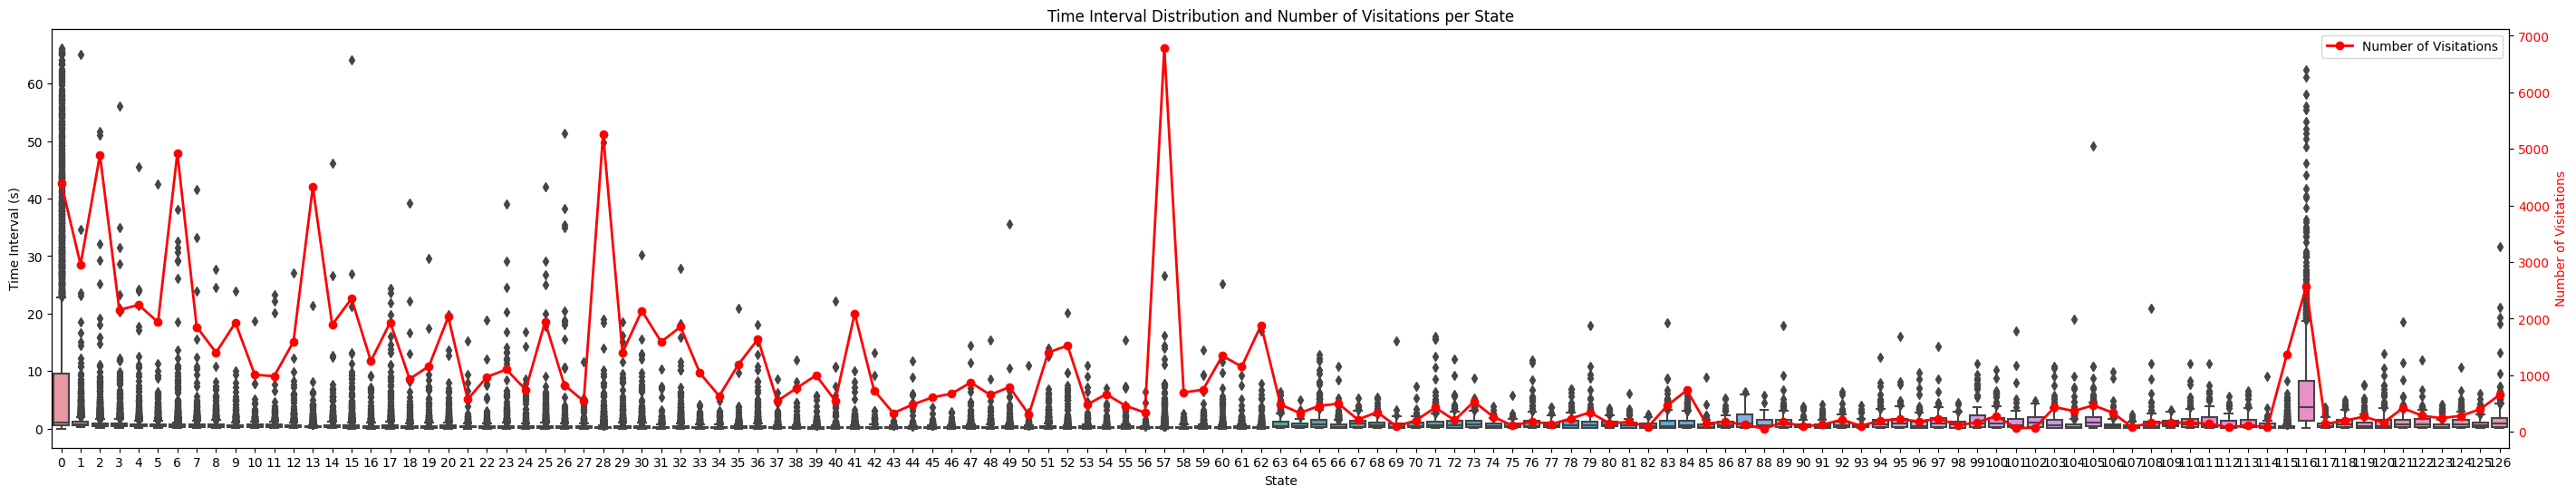

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def compute_state_intervals(times, emissions, blist):
    """
    For each trial (row in times and emissions), compute the time interval for every time point
    (current time minus previous time) as long as the time is not a wrap-around (i.e. times[t] >= times[t-1]).
    The computed interval is appended to the list for the state given by emissions[t].
    
    Parameters:
      times:      2D numpy array (n_trials x trial_length) of time values.
      emissions:  2D numpy array (n_trials x trial_length) of state identifiers.
    
    Returns:
      state_intervals: dict mapping each state to a list of time intervals.
    """
    state_intervals = {}
    n_trials, trial_length = times.shape
    
    for trial in range(n_trials):
        for t in range(0, trial_length-1):
            # If a wrap-around is detected, skip this interval.
            if times[trial, t+1] < times[trial, t]:
                if blist[trial, t+1, 0] > blist[trial, t, 1]:
                    delta_t = blist[trial, t+1, 0] - blist[trial, t, 1]
                else:
                # print(emissions[trial, t], times[trial, t], emissions[trial, t-1], times[trial, t-1])
                    continue
            else:
                delta_t = times[trial, t+1] - times[trial, t]
            if delta_t >= 2000:
                print(trial)
                # print(emissions[trial, t], times[trial, t], emissions[trial, t-1], times[trial, t-1])
                continue
            state = emissions[trial, t]
            
            # Initialize the list for this state if it hasn't been seen yet.
            if state not in state_intervals:
                state_intervals[state] = []
            state_intervals[state].append(delta_t)
    
    return state_intervals

state_intervals = compute_state_intervals(times[:], emissions[:, :, 0], b_list)

rows = []
for state, intervals in state_intervals.items():
    for interval in intervals:
        rows.append({'state': state, 'interval': interval/30})
df = pd.DataFrame(rows)

# Ensure that states are ordered (alphabetical order in this case).
states = sorted(df['state'].unique())

# Create the box plot using Seaborn.
plt.figure(figsize=(35, 6))
ax = sns.boxplot(data=df, x='state', y='interval', order=states)
ax.set_xlabel('State')
ax.set_ylabel('Time Interval (s)')
ax.set_title('Time Interval Distribution and Number of Visitations per State')

# Compute the count (number of visitations) for each state.
counts = [df[df['state'] == state].shape[0] for state in states]

# Create a twin axis to overlay the line plot for the number of visitations.
ax2 = ax.twinx()
# Plot the counts. Here, x positions are aligned with the categorical positions: 0, 1, 2, ...
ax2.plot(range(len(states)), counts, color='red', marker='o', linestyle='-', linewidth=2, label='Number of Visitations')
ax2.set_ylabel('Number of Visitations', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Optionally, add a legend for the line plot.
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='upper right')

plt.show()

In [11]:
import numpy as np

def convert_emissions(times, emissions, blist, trans_probs):
    """
    Convert and expand the emissions sequence according to time-interval rules.
    
    Parameters:
      times:      2D numpy array of shape (n_trials, trial_length) with time values.
      emissions:  3D numpy array of shape (n_trials, trial_length, 2) where:
                    - emissions[:, :, 0] are state identifiers (used to index trans_probs)
                    - emissions[:, :, 1] are action identifiers.
      blist:      3D numpy array of shape (n_trials, trial_length, 2) used for wrap-around handling.
      trans_probs:3D numpy array of shape (n_states, n_actions, n_states). For self-transitions,
                  actions will be sampled from trans_probs[s, :, s] (normalized to sum to 1).
    
    Returns:
      new_emissions: 3D numpy array of shape (n_trials, 500, 2) with the converted sequence.
                     Column 0 is the state; column 1 is the action.
    """
    n_trials, trial_length = times.shape
    new_emissions = []  # List to collect converted emissions for each trial

    for trial in range(n_trials):
        expanded = []  # Will hold tuples (state, action)
        # Add the very first timepoint as-is.
        
        # Process each transition from time index t to t+1.
        for t in range(trial_length - 1):
            # Compute delta_t using wrap-around logic.
            if times[trial, t+1] < times[trial, t]:
                # Wrap-around: use blist if condition is met.
                if blist[trial, t+1, 0] > blist[trial, t, 1]:
                    delta_t = blist[trial, t+1, 0] - blist[trial, t, 1]
                else:
                    delta_t = 1
                    # continue  # skip this transition if condition is not met.
            else:
                delta_t = times[trial, t+1] - times[trial, t]
            
            # Skip transitions with excessively large intervals.
            # if delta_t >= 2000:
            #     print(f"Skipping trial {trial} at index {t} due to large delta_t: {delta_t}")
            #     continue

            # Determine the expansion factor based on delta_t.
            if delta_t < 60:
                num_timepoints = 1
            elif 60 <= delta_t <= 500:
                num_timepoints = 2
            else:
                num_timepoints = 3

            provided_action = emissions[trial, t, 1]
            curr_state = emissions[trial, t, 0]
            
            if num_timepoints == 1:
                # If expansion factor is 1, use the provided action.
                expanded.append((curr_state, provided_action))
            else:
                p = trans_probs[curr_state, :, curr_state]
                p_sum = np.sum(p)
                if p_sum == 0:
                    1/0
                else:
                    p_norm = p / p_sum
                # Sample num_timepoints actions.
                sampled_actions = np.random.choice(np.arange(len(p_norm)), size=num_timepoints-1, p=p_norm)
                for act in sampled_actions:
                    expanded.append((curr_state, act))
                expanded.append((curr_state, provided_action))
        
        expanded.append((emissions[trial, -1, 0], emissions[trial, -1, 1]))
        
        # Ensure each trial has exactly 500 timepoints.
        if len(expanded) >= 500:
            truncated = expanded[:500]
        else:
            1/0
        new_emissions.append(truncated)
    
    # Convert the list of lists into a numpy array with shape (n_trials, 500, 2)
    new_emissions = np.array(new_emissions)
    return new_emissions

converted_emissions = convert_emissions(times, emissions, b_list, trans_probs)


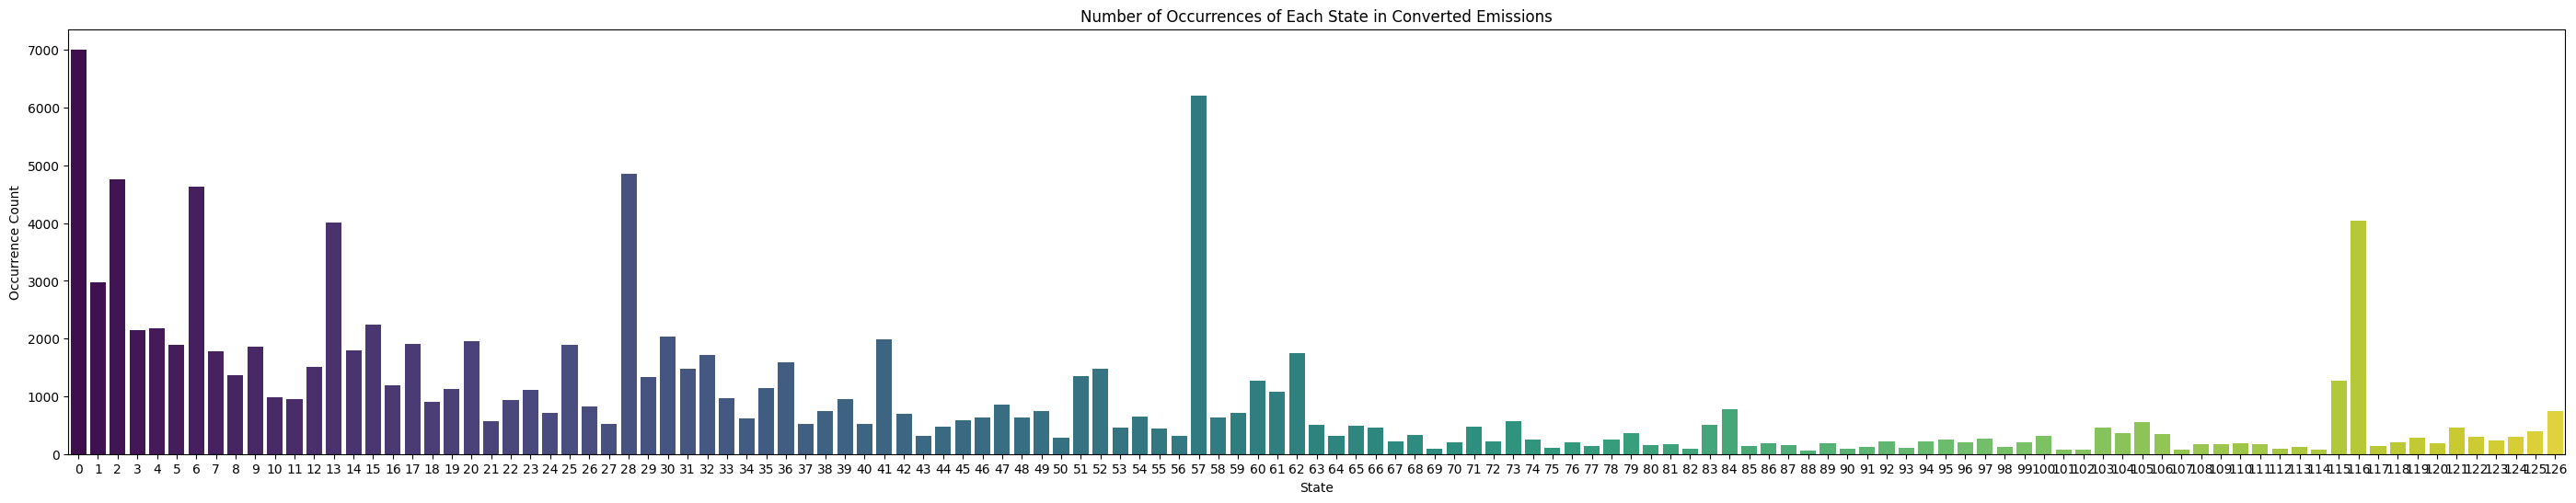

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume converted_emissions is your (n_trials, 500, 2) array.
# For example:
# converted_emissions = convert_emissions(times, emissions, blist, trans_probs)

# Extract the state column (column 0) from converted_emissions.
states = converted_emissions[:, :, 0]

# Flatten the array to 1D.
states_flat = states.flatten()

# Remove NaN values (if any exist from padding).
states_flat = states_flat[~pd.isnull(states_flat)]

# Count the occurrences of each state.
unique_states, counts = np.unique(states_flat, return_counts=True)

# Create a DataFrame for easier plotting with Seaborn.
df_counts = pd.DataFrame({
    'state': unique_states,
    'count': counts
})

# Plot using Seaborn's barplot.
plt.figure(figsize=(35, 6))
sns.barplot(data=df_counts, x='state', y='count', palette='viridis')
plt.xlabel('State')
plt.ylabel('Occurrence Count')
plt.title('Number of Occurrences of Each State in Converted Emissions')
plt.show()


In [13]:
# node visitation with time intervals info
np.save('converted_emissions500new.npy', converted_emissions)

(238, 500, 2)


In [14]:
# raw node visitation
emissions = np.array(emissions_list)
np.save('emissions500new.npy', emissions)

In [15]:
xy_list = np.array(xy_list, dtype=object)
np.save('xy_list500new.npy', xy_list, allow_pickle=True)